In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_bvp
from scipy import special as sp
from scipy import stats
import plasmapy.mathematics
from functools import partial
import scipy.optimize as op
from scipy import fftpack
from scipy import integrate
from scipy import signal
%config InlineBackend.figure_format = 'svg'
from prettytable import PrettyTable
import quadpy

In [3]:
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]

def eq4PDRK(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    v_th_kappa = np.sqrt(2-3/kappa) * np.sqrt(tem)
    zeta = wc / k /v_th_kappa
    r = 1 + (kappa/(kappa-1.5)) * 1 / k**2 / l_D**2 * ( 1 - 1/2/kappa + zeta*dispersion_function(zeta) )
    return [r.real,r.imag]

def dispersion_function(zeta):
    r = 0.0
    A_kappa = (kappa)**(-1.5) * sp.gamma(kappa+1) / sp.gamma(kappa-0.5)
    def integrand(xi):
        return  (1+xi**2/kappa)**(-kappa-1)
        #return np.exp(-xi**2)
    if zeta.imag>0:
        r = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,np.inf)[0]
    elif zeta.imag==0:
        x = 0.1
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1 = (1/np.sqrt(np.pi)) * integrate.quad(integrand,s_n,s_p, weight='cauchy',wvar=zeta.real)[0]
        real2 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = real + 1j*imag
    elif zeta.imag<0:
        x = 1e-8
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1a = -1j * quadpy.quad(lambda xi_i: integrand(s_n+1j*xi_i)/(1j*xi_i-1j*zeta.imag-x),zeta.imag,0)[0]
        real1b =  1j * quadpy.quad(lambda xi_i: integrand(s_p+1j*xi_i)/(1j*xi_i-1j*zeta.imag+x),zeta.imag,0)[0]
        real2 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1a+real1b+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = (1/np.sqrt(np.pi)) * real + 1j*imag
    return r * A_kappa

def fk(v, t, kappa):
    r = 0
    if(kappa == 0):
        r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    else:
        r = np.sqrt(m/(2.*np.pi*t*(kappa-1.5))) * sp.gamma(kappa) / \
            sp.gamma(kappa-0.5) * (1 + m*v**2 / (kappa-1.5) / 2 / t) ** (-kappa)
    return r

In [40]:
tem = 1
#L = 80
#k = 5*2*np.pi / L
k = 0.1
L = 2*np.pi/k
vmax = 100  # 10 * np.sqrt(tem)
nx = 1001
nv = 1001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.01
max_steps  = 15000
data_steps = 100
data_num = int(max_steps/data_steps)+1
d = 0.001
kappa = 2

path = './data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt(tem) # $\lambda_D^2$
w_pe = 1

print("data_num = ",data_num)
print("k = ",k)
if (kappa==0):
    s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
else:
    s=op.root(lambda w:eq4PDRK(w,k),[1,0.1])
v_p = s.x[0]/k
wr_theo = s.x[0]
wi_theo = s.x[1]
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("t_Bi = ", abs(1/np.sqrt(q*d)))

print("t_L = ", abs(1/s.x[1]))
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

data_num =  151
k =  0.1
w_r =  1.0138503007984883
w_i =  -0.0035850250127402194
v_p =  10.138503007984882
t_Bi =  31.622776601683796
t_L =  278.9380817278171
limited time= 314.15926535897927
real time =  150.0


In [41]:
progesses = np.arange(0,data_num,1)

f = []
E = []
T_x0 = []
n_x0 = []
E_x0 = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    E_temp = np.loadtxt(os.path.join(path,"E"+str(progess)))
    E.append(E_temp)
    E_x0.append(E_temp[0])
    f_temp_x0 = f_temp[0,:]
    fx_temp_x0 = np.sum(f_temp_x0)*dv
    T_temp_x0 = np.sum(v**2*f_temp_x0)*dv/fx_temp_x0
    T_x0.append(T_temp_x0)
    n_x0.append(fx_temp_x0)

In [42]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

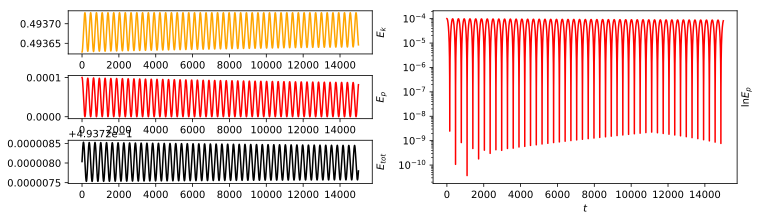

In [43]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

## 实验结果

### 分布函数fx fv

In [44]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L
T0 = np.sum(v**2*f[0],axis=1)*dv/fx0
T = np.sum(v**2*f[data_num-1],axis=1)*dv/fx

print('f0_norm: ',np.sum(fv0)*dv)
print('f_norm:  ',np.sum(fv)*dv)
print('T0_aver:',T0.mean())
print('T_aver: ',T.mean())

f0_norm:  1.0010005962987483
f_norm:   1.0010004273274298
T0_aver: 0.987281585475767
T_aver:  0.9873062777485295


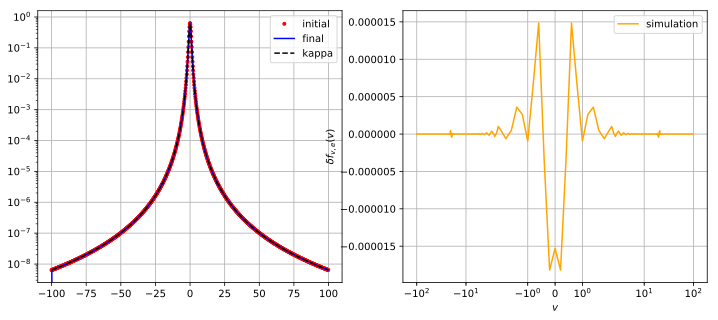

In [45]:
vstart = -vmax
vend = vmax
nvs = int((vstart + vmax ) / dv)
nve = int((vend + vmax) /dv)

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v[nvs:nve],fv0[nvs:nve],'.',color='r',label='initial')
ax1.plot(v[nvs:nve],fv[nvs:nve],color='blue',label='final')
ax1.plot(v[nvs:nve],fk(v[nvs:nve],tem,kappa),'--',color='black',label='kappa')
ax1.set_yscale('log')

ax2.plot(v, fv-fv0, color='orange', label='simulation')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$\delta f_{v,e}(v)$')
ax2.set_xscale('symlog')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

### 密度&温度分布

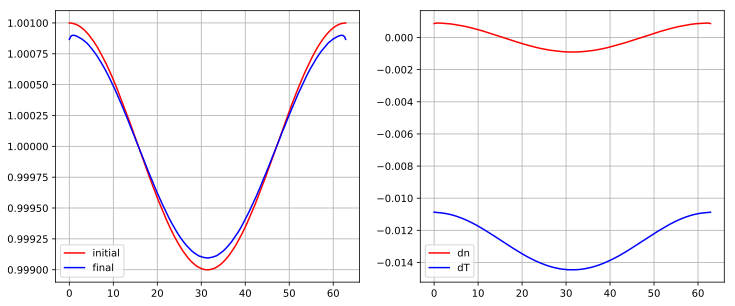

In [46]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(x,fx0,color='r',label='initial')
ax1.plot(x,fx,color='blue',label='final')

dn = fx - 1
dT = T - 1
#dn_maxidx, _ = signal.find_peaks(dn, distance=5)
#dn_minidx, _ = signal.find_peaks(-dn, distance=5)
#dT_maxidx, _ = signal.find_peaks(dT, distance=5)
#dT_minidx, _ = signal.find_peaks(-dT, distance=5)

ax2.plot(x,dn,color='r',label='dn')
#ax2.plot(x[dn_maxidx[0:2]],dn[dn_maxidx[0:2]],'x',color='r')
#ax2.plot(x[dn_minidx[0:2]],dn[dn_minidx[0:2]],'x',color='r')

ax2.plot(x,dT,color='blue',label='dT')
#ax2.plot(x[dT_maxidx[0:2]],dT[dT_maxidx[0:2]],'o',color='blue')
#ax2.plot(x[dT_minidx[0:2]],dT[dT_minidx[0:2]],'o',color='blue')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

In [47]:
#dn_A = np.mean(dn[dn_maxidx[0:4]]-dn[dn_minidx[0:4]])
#dT_A = np.mean(dT[dT_maxidx[0:4]]-dT[dT_minidx[0:4]])
dn_A = dn[0]-dn[nx//2]
dT_A = dT[0]-dT[nx//2]
print(round(dT_A/dn_A+1,6))

3.024886


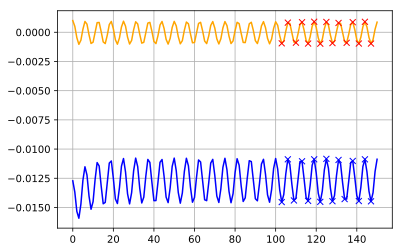

In [48]:
dn_x0 = np.array(n_x0) - 1
dT_x0 = np.array(T_x0) - tem

extre_s = 100
extre_e = 150

dn_maxidx, _ = signal.find_peaks(dn_x0[extre_s:extre_e], distance=5)
dn_minidx, _ = signal.find_peaks(-dn_x0[extre_s:extre_e], distance=5)
dT_maxidx, _ = signal.find_peaks(dT_x0[extre_s:extre_e], distance=5)
dT_minidx, _ = signal.find_peaks(-dT_x0[extre_s:extre_e], distance=5)

plt.plot(progesses,dT_x0,color='blue')
plt.plot(progesses,dn_x0,color='orange')

plt.plot(extre_s+dn_maxidx,dn_x0[extre_s+dn_maxidx],'x',color='r')
plt.plot(extre_s+dn_minidx,dn_x0[extre_s+dn_minidx],'x',color='r')

plt.plot(extre_s+dT_maxidx,dT_x0[extre_s+dT_maxidx],'x',color='b')
plt.plot(extre_s+dT_minidx,dT_x0[extre_s+dT_minidx],'x',color='b')

plt.grid()
plt.show()

In [49]:
dn_x0A = np.mean(dn_x0[extre_s+dn_maxidx])-np.mean(dn_x0[extre_s+dn_minidx])
dT_x0A = np.mean(dT_x0[extre_s+dT_maxidx])-np.mean(dT_x0[extre_s+dT_minidx])
print(round(dT_x0A/dn_x0A+1,6))

2.952789


In [50]:
table5 = PrettyTable(['k\kappa','2','3','4','5','10','infty'])
print('vmax = 50; t = 150; d=0.001')
table5.add_row(['0.05','-/-','3.083989/3.08018','3.043292/3.043351','3.032692/3.031615','3.020581/3.020361','3.015297/3.015109'])
table5.add_row(['0.10','-/-','-/-','-/-','-/3.144775','3.093512/3.086605','3.06285/3.062439'])
table5.add_row(['0.15',2,3,4,5,10,0])
table5.add_row(['0.20',2,3,4,5,10,0])
table5.add_row(['0.25',2,3,4,5,10,0])
print(table5)

vmax = 50; t = 150; d=0.001
+---------+-----+------------------+-------------------+-------------------+-------------------+-------------------+
| k\kappa |  2  |        3         |         4         |         5         |         10        |       infty       |
+---------+-----+------------------+-------------------+-------------------+-------------------+-------------------+
|   0.05  | -/- | 3.083989/3.08018 | 3.043292/3.043351 | 3.032692/3.031615 | 3.020581/3.020361 | 3.015297/3.015109 |
|   0.10  | -/- |       -/-        |        -/-        |     -/3.144775    | 3.093512/3.086605 |  3.06285/3.062439 |
|   0.15  |  2  |        3         |         4         |         5         |         10        |         0         |
|   0.20  |  2  |        3         |         4         |         5         |         10        |         0         |
|   0.25  |  2  |        3         |         4         |         5         |         10        |         0         |
+---------+-----+------------------+